## Model the redshift errors and Compare the modes

In [187]:
import os
import sys
import fitsio
import numpy as np
import pandas as pd
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d

sys.path.append('/global/homes/s/shengyu/desi_y3_redshift_errors/main/')
from helper import REDSHIFT_OVERALL, COLOR_OVERALL
from helper import REDSHIFT_VSMEAR, REDSHIFT_LSS_VSMEAR, REDSHIFT_CUBICBOX, COLOR_TRACERS, GET_RECON_BIAS
%load_ext autoreload
%autoreload 2

Z_SMEAR = REDSHIFT_VSMEAR

# save the figure to the overleaf or not
save_fig = True

OVERLEAF_DIR = '/global/homes/s/shengyu/desi_y3_redshift_errors/overleaf/figures'
REPEAT_DIR = '/pscratch/sd/s/shengyu/repeats/DA2/loa-v1'
RESULT_DIR = '/global/homes/s/shengyu/desi_y3_redshift_errors/main/repeat_obs/results'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [210]:
def generate_dv(tracer, zmin, zmax):
    c = 299792.458
    d = Table.read(f'{REPEAT_DIR}/{tracer}repeats.fits', hdu=1)
    sel      = np.full(len(d),True)
    sel = np.isfinite(d['Z1']) & np.isfinite(d['Z2'])
    selz = ((zmin<d["Z1"])&(d["Z1"]<zmax))
    # d_zbin = d[sel]
    d_zbin = d[sel & selz]
    dv_zbin = (d_zbin['Z2']-d_zbin['Z1'])/(1+d_zbin['Z1'])*c
    return dv_zbin

def get_cthr(tracer):
    if tracer in ['BGS', 'LRG', 'ELG']:
        cthr = 1000
    elif tracer in ['QSO']:
        cthr = 10000
    elif tracer in ['QSO_3cut']:
        cthr = 3000
    return cthr

In [211]:
tracer = 'ELG'
(zmin, zmax) = REDSHIFT_OVERALL[tracer]
color = COLOR_OVERALL[tracer]

dv = generate_dv(tracer, zmin, zmax)

cthr = 10000 if tracer == 'QSO' else 1000
dv_smear = dv[abs(dv) < cthr]
median_dv = np.median(abs(dv))
RMS = np.sqrt(np.mean(dv_smear**2))   
fc= np.mean(abs(dv) >= cthr)*100
print(len(dv), median_dv, RMS, fc)

481085 8.583098001460657 28.15987829202078 0.23072845754908175


## Model the redshift errors

In [189]:
def suggest_vbin(dv, vmode='linear', bw_method='scott', points_per_sigma=3):
    """
    Suggest an optimal linear dv bin width for evaluating the KDE model.

    The recommended bin width is computed as:
        vbin ≈ σ_KDE / points_per_sigma,
    where σ_KDE = kde.factor * std(v) (or |v| if use_abs=True).
    """
    v = np.asarray(dv, float)
    v = v[np.isfinite(v)]
    if 'log' in vmode:
        y = np.log10(np.abs(v))
    elif 'linear' in vmode:
        y = v
    kde = gaussian_kde(y, bw_method=bw_method)
    bw  = kde.factor * y.std()  # σ_KDE in linear dv space
    vbin = bw / points_per_sigma
    return vbin, bw

tracer = 'QSO'
(zmin, zmax) = REDSHIFT_OVERALL[tracer]
color = COLOR_OVERALL[tracer]
dv = generate_dv(tracer, 0.8, 2.1)
cthr = 10000 if tracer == 'QSO' else 1000
dv_smear = dv[abs(dv) < cthr]
median_dv = np.median(abs(dv))
RMS = np.sqrt(np.mean(dv_smear**2))   
fc= np.mean(abs(dv) >= cthr)*100
print(len(dv), median_dv, RMS, fc)

suggest_vbin(dv,)

252633 90.96354368041621 471.2414468029257 0.6056215933785372


/global/homes/s/shengyu/.conda/envs/rc_env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


(347.78094626037796, 1043.3428387811339)

## Compare the modeled CDF to the real repeats

In [221]:
def compute_quantites(dv, cthr):
    dv_smear = dv[np.abs(dv) < cthr]
    median_dv = np.median(np.abs(dv))
    RMS       = np.sqrt(np.mean(dv_smear**2))
    fc        = np.mean(np.abs(dv) >= cthr) * 100
    qu = dict(number=len(dv), median=median_dv, RMS=RMS, fc=fc)
    return qu

def sample_from_cdf(cdf_fn, Ngal, vmode, seed=53):
    """Load the |dv| KCDF and sample dv."""
    data = np.load(cdf_fn, allow_pickle=True)
    grid = data["grid"]
    cdf  = data["cdf"]
    cdf_unique, ind = np.unique(cdf, return_index=True)
    grid_unique = grid[ind]
    inv_cdf = interp1d(
        cdf_unique / cdf_unique[-1],
        grid_unique,
        bounds_error=False,
        fill_value=(grid_unique[0], grid_unique[-1]),
        kind='linear'
    )
    np.random.seed(seed)
    if 'log' in vmode:
        if 'abs' in vmode:
            u = np.random.uniform(0, 1, int(Ngal / 2))
            y = inv_cdf(u)
            dv = np.append(10**y, -10**y)
            if Ngal % 2 == 1:
                dv = np.append([0.0], dv)
            np.random.shuffle(dv)
        elif 'signed' in vmode:
            u = np.random.uniform(0, 1, int(Ngal))
            y = inv_cdf(u)
            dv = np.append(10**y, -10**y)
    elif 'linear' in vmode:
        u = np.random.uniform(0, 1, int(Ngal))
        dv = inv_cdf(u)
    return dv, inv_cdf

def model_dv_from_kcdf(vmode, tracer, z1, z2, dv_real):
    """Return dv_model array for a given mode and (tracer, z-bin)."""
    if vmode == "log_abs":
        N = len(dv_real)
        fn = f"{REPEAT_DIR}/vmode/KCDF_{tracer}_z{z1:.1f}-{z2:.1f}_{vmode}.npz"
        dv_model, _ = sample_from_cdf(fn, N, vmode)
        return np.asarray(dv_model, float)
    elif vmode == "log_signed":
        dv_nz = dv_real[dv_real != 0]
        N_p = np.sum(dv_nz > 0)
        N_n = np.sum(dv_nz < 0)
        dv_model_list = []
        for sign, N in [('+', N_p), ('-', N_n)]:
            fn = f"{REPEAT_DIR}/vmode/KCDF_{tracer}_z{z1:.1f}-{z2:.1f}_{vmode}_{sign}.npz"
            sample, _ = sample_from_cdf(fn, N, vmode)
            sample = np.asarray(sample, float)
            dv_model_list.append(sample if sign == '+' else -sample)
        return np.concatenate(dv_model_list)
    elif vmode == "linear":
        N = len(dv_real)
        fn = f"{REPEAT_DIR}/vmode/KCDF_{tracer}_z{z1:.1f}-{z2:.1f}_{vmode}.npz"
        dv_model, _ = sample_from_cdf(fn, N, vmode)
        return np.asarray(dv_model, float)
    else:
        raise ValueError(f"Unknown mode: {vmode}")

def build_kcdf_comparison(vmode, tracers, result_dir=RESULT_DIR, step=0.1):
    rows = []
    for tracer in tracers:
        zmin, zmax = REDSHIFT_OVERALL[tracer]
        cthr = 10000 if tracer == "QSO" else 1000
        # --- ALL-z bin ---
        dv_real = generate_dv(tracer, zmin, zmax)
        dv_real = np.asarray(dv_real, float)
        dv_real = dv_real[np.isfinite(dv_real)]
        if len(dv_real) > 0:
            real_stats  = compute_quantites(dv_real, cthr)
            dv_model    = model_dv_from_kcdf(vmode, tracer, zmin, zmax, dv_real)
            model_stats = compute_quantites(dv_model, cthr)
            rows.append(dict(
                tracer=tracer, zmin=zmin, zmax=zmax,
                N_real=real_stats["number"],
                median_real=real_stats["median"],
                median_model=model_stats["median"],
                RMS_real=real_stats["RMS"],
                RMS_model=model_stats["RMS"],
                fc_real=real_stats["fc"],
                fc_model=model_stats["fc"],
            ))
        # --- 0.1-z bins ---
        zrange = np.round(np.arange(zmin, zmax + step / 2, step), 1)
        for z1, z2 in zip(zrange[:-1], zrange[1:]):
            dv_real = generate_dv(tracer, z1, z2)
            dv_real = np.asarray(dv_real, float)
            dv_real = dv_real[np.isfinite(dv_real)]
            if len(dv_real) == 0:
                continue
            real_stats  = compute_quantites(dv_real, cthr)
            dv_model    = model_dv_from_kcdf(vmode, tracer, z1, z2, dv_real)
            model_stats = compute_quantites(dv_model, cthr)
            rows.append(dict(
                tracer=tracer, zmin=z1, zmax=z2,
                N_real=real_stats["number"],
                median_real=real_stats["median"],
                median_model=model_stats["median"],
                RMS_real=real_stats["RMS"],
                RMS_model=model_stats["RMS"],
                fc_real=real_stats["fc"],
                fc_model=model_stats["fc"],
            ))
    df = pd.DataFrame(rows)
    df.to_csv(result_dir + f"/KCDF_{vmode}_comparison.csv", index=False)
    return df

def compute_model_vs_real_chi2(vmode, metrics_tab, result_dir=RESULT_DIR):
    df = pd.read_csv(result_dir + f"/KCDF_{vmode}_comparison.csv")
    chi2_tot, ndof = 0.0, 0
    for _, row in df.iterrows():
        tracer = row["tracer"]
        z1, z2 = row["zmin"], row["zmax"]
        metrics_name = f"{tracer[:3]}_z{z1}_{z2}"
        var_row = metrics_tab[metrics_tab["tracer"] == metrics_name]
        if len(var_row) == 0:
            continue
        sigmas = {
            "median": float(var_row["med_std"][0]),
            "RMS":    float(var_row["rms_std"][0]),
            "fc":     float(var_row["fc_std"][0]),
        }
        for metric, sigma in sigmas.items():
            if sigma <= 0 or not np.isfinite(sigma):
                continue
            delta = row[f"{metric}_model"] - row[f"{metric}_real"]
            chi2_tot += (delta / sigma) ** 2
            ndof += 1
    chi2_per_dof = chi2_tot / ndof if ndof > 0 else np.nan
    return chi2_tot, ndof, chi2_per_dof


In [231]:
# ============================
# Run everything
# ============================
GLOBAL_SEED = 12345

tracers = ['LRG', 'ELG', 'QSO']

# load variances and compute chi^2
var_method = 'bootstrap'  # 'jackknife', 'bootstrap'
metrics_tab = Table.read(RESULT_DIR+f'/repeat_metrics_{var_method}.csv', format="csv")

# build comparison tables for both modes
for vmode in ["log_abs", "log_signed", "linear"]:
    build_kcdf_comparison(vmode, tracers)
    chi2, ndof, chi2nu = compute_model_vs_real_chi2(vmode, metrics_tab)
    print("{} \ \ \t : chi2 = {:.2f}, ndof = {}, chi2/ndof = {:.2f}".format(vmode, 
        chi2, ndof, chi2nu))

log_abs \ \ 	 : chi2 = 724.58, ndof = 93, chi2/ndof = 7.79
log_signed \ \ 	 : chi2 = 957.39, ndof = 93, chi2/ndof = 10.29
linear \ \ 	 : chi2 = 502379299.92, ndof = 93, chi2/ndof = 5401927.96


In [230]:
tracers = ['LRG', 'ELG', 'QSO']
step = 0.1
vmodes = ['log_abs', 'log_signed']
kcdf_comp = {
    vmode: pd.read_csv(RESULT_DIR + f"/KCDF_{vmode}_comparison.csv")
    for vmode in vmodes
}

var_method = 'bootstrap' # bootstrap, jackknife
metrics_fn = RESULT_DIR+f'/repeat_metrics_{var_method}.csv'
metrics_tab = Table.read(metrics_fn, format="csv")

overall_values = {
    'BGS': [13.3, 36.0, 0.51],
    'LRG': [40.7, 82.1, 0.46],
    'ELG': [8.6, 28.2, 0.23],
    'QSO': [91.0, 471.2, 0.61],
} # med_mean, rms_mean, fc_mean

markers = ['o', 's', '^', 'D', 'v', '*', 'x', 'P']
fig = plt.figure(figsize=(18, 4))
gs = gridspec.GridSpec(1,3,width_ratios=[1, 1, 1],
                       wspace=0.24,hspace=0.1,left=0.05, right=0.98, top=0.95, bottom=0.05)
for idxt, tracer in enumerate(tracers):
    (zmin, zmax) = REDSHIFT_OVERALL[tracer[:3]]
    zrange = np.round(np.arange(zmin, zmax+ step/2, step), 1)
    zbins = list(zip(zrange[:-1], zrange[1:]))
    color = COLOR_OVERALL[tracer[:3]]
    marker = markers[idxt]
    zmid_list, median_list, rms_list, fc_list = [], [], [], []

    # lists for MODEL metrics per mode
    mode_metric_lists = {
        vmode: {"median": [], "RMS": [], "fc": []} for vmode in vmodes
    }
    for indz, (z1, z2) in enumerate(zbins):
        dv = generate_dv(tracer[:3], z1, z2)
        # ===== quantities of dv =====
        cthr = get_cthr(tracer)
        dv_smear = dv[abs(dv) < cthr]
        median_dv = np.median(abs(dv))
        RMS = np.sqrt(np.mean(dv_smear**2))    
        fc= np.mean(abs(dv) >= cthr)*100 # fc = (np.sum(abs(dv) > cthr)) /len(dv)*100
        var = metrics_tab[metrics_tab["tracer"] == f"{tracer[:3]}_z{z1}_{z2}"]
        zmid_list.append((z1 + z2) / 2)
        median_list.append((median_dv, var['med_std'][0])) # in km/s
        rms_list.append((RMS, var['rms_std'][0])) # in km/s
        fc_list.append((fc, var['fc_std'][0])) # in %
        # ===== MODEL metrics from KCDF comparison tables =====
        for vmode in vmodes:
            df_mode = kcdf_comp[mode]
            row = df_mode[
                (df_mode["tracer"] == tracer) &
                (df_mode["zmin"] == z1) &
                (df_mode["zmax"] == z2)
            ]
            row = row.iloc[0]
            mode_metric_lists[vmode]["median"].append(row["median_model"])
            mode_metric_lists[vmode]["RMS"].append(row["RMS_model"])
            mode_metric_lists[vmode]["fc"].append(row["fc_model"])

    # === Plot panels ===
    metric_lists = [median_list, rms_list, fc_list]
    qlabels = ['med_std', 'rms_std','fc_std']
    ylabels = [r"Median [km/s]", r"RMS [km/s]", r"$f_{\mathrm{catas}}$ [%]"]
    for idxq, (vals, ylabel) in enumerate(zip(metric_lists, ylabels)):
        means, errs = zip(*vals)            # unzip -> two tuples
        ax = plt.subplot(gs[idxq])
        # ax.scatter(zmid_list, means, color=color, s=30, label=tracer)
        ax.errorbar(zmid_list, means, yerr = errs, label = tracer, 
                    marker= 'o', markersize=3, 
                    color = color, linestyle='none',)
        ax.plot(zmid_list, means, color=color, lw=1.2, alpha=0.6)

        # ===== MODEL points (two KCDF modes) =====
        for vmode in vmodes:
            if idxq == 0:
                y_mode = mode_metric_lists[vmode]["median"]
            elif idxq == 1:
                y_mode = mode_metric_lists[vmode]["RMS"]
            else:
                y_mode = mode_metric_lists[vmode]["fc"]

            if len(y_mode) == 0:
                continue  # in case some bins were skipped

            # Different markers/styles for the two modes
            mode_marker = "s" if vmode == "log_abs" else "D"
            mode_ls = "none"
            mode_alpha = 0.4

            # Only label once per mode to avoid huge legends
            if idxt == 0:
                mode_label = vmode
            else:
                mode_label = None

            ax.plot(
                zmid_list[:len(y_mode)], y_mode,
                marker=mode_marker, linestyle=mode_ls,
                color=color, alpha=mode_alpha,
                label=mode_label,
            )
        # === add horizontal line for global value ===
        yvalue = overall_values[tracer][idxq]
        yvar = metrics_tab[metrics_tab["tracer"] == f"{tracer[:3]}_z{zmin}_{zmax}"][qlabels[idxq]][0]
        ax.axhline(y=yvalue, color=color, linestyle='--', lw=1.4, alpha=0.6 if tracer == 'QSO_3cut' else 1.0)
        # ax.axhspan(yvalue-yvar, yvalue+yvar, color=color, alpha=0.3)
        # plot axes settings
        ax.set_xlabel(r"$z_{\mathrm{bin}}$", fontsize=14)
        ax.set_ylabel(ylabel, fontsize=12)
        ax.tick_params(axis='both', labelsize=11)
        ax.grid(alpha=0.3)
        if idxq==0 and idxt==0:
            ax.legend(fontsize=12, loc='best', frameon=False)

KeyError: 'linear'

<Figure size 1800x400 with 0 Axes>

In [123]:
import numpy as np
import pandas as pd

def compute_model_vs_real_chi2(mode, metrics_tab, result_dir=RESULT_DIR):
    """
    Compute a chi^2-like score between model and real metrics for a given KCDF mode.
    
    mode : str
        'log_abs', 'log_signed', etc. Used to load KCDF_{mode}_comparison.csv.
    metrics_tab : astropy.table.Table
        Table with columns:
            'tracer' (e.g. 'LRG_z0.3_0.4'),
            'med_std', 'rms_std', 'fc_std'
        as in your existing code.
    result_dir : str
        Base directory where KCDF_{mode}_comparison.csv lives.
    """
    df = pd.read_csv(result_dir + f"/KCDF_{mode}_comparison.csv")

    chi2_tot = 0.0
    ndof = 0

    for _, row in df.iterrows():
        tracer = row["tracer"]      # e.g. 'LRG', 'ELG', 'QSO'
        z1 = row["zmin"]
        z2 = row["zmax"]

        # This matches how you select from metrics_tab in your plot code
        metrics_name = f"{tracer[:3]}_z{z1}_{z2}"
        var_row = metrics_tab[metrics_tab["tracer"] == metrics_name]

        if len(var_row) == 0:
            # no matching variance row → skip this bin
            continue

        sigma_med = float(var_row["med_std"][0])
        sigma_rms = float(var_row["rms_std"][0])
        sigma_fc  = float(var_row["fc_std"][0])

        # Each metric contributes (Δ / σ)^2
        for metric, sigma in [
            ("median", sigma_med),
            ("RMS",    sigma_rms),
            ("fc",     sigma_fc),
        ]:
            if sigma <= 0 or not np.isfinite(sigma):
                continue

            delta = row[f"{metric}_model"] - row[f"{metric}_real"]
            chi2_tot += (delta / sigma) ** 2
            ndof += 1

    chi2_per_dof = chi2_tot / ndof if ndof > 0 else np.nan
    return chi2_tot, ndof, chi2_per_dof

In [124]:
var_method = 'bootstrap' # bootstrap, jackknife
metrics_fn = RESULT_DIR+f'/repeat_metrics_{var_method}.csv'
metrics_tab = Table.read(metrics_fn, format="csv")

chi2_abs, ndof_abs, chi2nu_abs = compute_model_vs_real_chi2("log_abs", metrics_tab)
chi2_sgn, ndof_sgn, chi2nu_sgn = compute_model_vs_real_chi2("log_signed", metrics_tab)

print("log_abs   : chi2 = {:.2f}, ndof = {}, chi2/ndof = {:.2f}".format(
    chi2_abs, ndof_abs, chi2nu_abs))
print("log_signed: chi2 = {:.2f}, ndof = {}, chi2/ndof = {:.2f}".format(
    chi2_sgn, ndof_sgn, chi2nu_sgn))

log_abs   : chi2 = 942.55, ndof = 93, chi2/ndof = 10.13
log_signed: chi2 = 1798.10, ndof = 93, chi2/ndof = 19.33


## Selection effects, bins effect

In [52]:
import numpy as np
from scipy.stats import gaussian_kde

v = np.abs(dv)
v = v[np.isfinite(v) & (v>0)]

# --- Baselines ---
# ECDF (binless)
v_sort = np.sort(v)
ecdf_y = np.arange(1, len(v_sort)+1) / len(v_sort)

# KDE (binless) on a common log grid
xmin, xmax = np.percentile(v, [0.1, 99.9])
x = np.logspace(np.log10(xmin), np.log10(xmax), 2000)
kde = gaussian_kde(np.log10(v))  # KDE in log-space is often better for heavy tails
pdf_kde_log = kde(np.log10(x)) / (x*np.log(10))  # change-of-variables to density in x
pdf_kde = pdf_kde_log
dx = np.diff(x); xm = 0.5*(x[1:]+x[:-1])

def js_divergence(p, q):
    p = p / (p.sum() + 1e-30)
    q = q / (q.sum() + 1e-30)
    m = 0.5*(p+q)
    kl = lambda a,b: np.sum(np.where(a>0, a*np.log((a+1e-30)/(b+1e-30)), 0.0))
    return 0.5*kl(p,m) + 0.5*kl(q,m)

records = []
# nbins_list = [30, 50, 80, 120, 180, 250]  # try a sweep
nbins_list = np.linspace(20, 200, 20, dtype=int)

for nb in nbins_list:
    edges = np.logspace(np.log10(xmin), np.log10(xmax), nb+1)
    counts, edges = np.histogram(v, bins=edges)
    widths = np.diff(edges)
    pdf = counts / (counts.sum() * widths)
    cdf = np.cumsum(pdf * widths)

    # interpolate binned CDF to ECDF x-grid (v_sort) to get KS distance
    cdf_x = 0.5*(edges[1:]+edges[:-1])
    cdf_interp = np.interp(v_sort, cdf_x, cdf, left=0, right=1)
    ks = np.max(np.abs(cdf_interp - ecdf_y))

    # compare PDF to KDE on common midpoints xm
    pdf_hist_on_x = np.interp(xm, cdf_x, pdf)
    # normalize on xm grid to avoid edge leakage differences
    pdf_hist_on_x = pdf_hist_on_x / (np.sum(pdf_hist_on_x*dx) + 1e-30)
    pdf_kde_on_x  = pdf_kde[:-1] / (np.sum(pdf_kde[:-1]*dx) + 1e-30)

    jsd = js_divergence(pdf_hist_on_x*dx, pdf_kde_on_x*dx)  # compare as discrete pmfs on xm

    # stability of key metrics
    fc_thr = 10000 if tracer == 'QSO' else 1000  # or 10000 for QSO
    fc_hist = np.trapz(pdf[cdf_x>=fc_thr], cdf_x[cdf_x>=fc_thr])
    p50 = np.interp(0.5, cdf, cdf_x)   # median
    p90 = np.interp(0.9, cdf, cdf_x)

    records.append((nb, ks, jsd, fc_hist, p50, p90))

# records now shows how KS/JSD and metrics vary with nbins

/global/homes/s/shengyu/.conda/envs/rc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(


In [53]:
columns = ['nbins', 'KS', 'JSD', 'fc_hist', 'p50', 'p90']
df = pd.DataFrame(records, columns=columns)
print(df)

    nbins        KS       JSD   fc_hist        p50         p90
0      20  0.084742  0.002961  0.003678  70.470643  430.960343
1      29  0.062945  0.000728  0.004083  74.902690  429.845731
2      38  0.049752  0.000316  0.004265  77.686601  434.254409
3      48  0.040451  0.000109  0.004650  79.235268  454.666690
4      57  0.034760  0.000078  0.004675  81.039789  457.952628
5      67  0.029952  0.000090  0.004792  82.312718  468.480638
6      76  0.026247  0.000065  0.004787  83.129040  470.951364
7      86  0.023301  0.000088  0.004774  84.107921  476.998961
8      95  0.021274  0.000154  0.004772  84.684904  479.141822
9     105  0.019382  0.000144  0.004766  85.188848  483.295083
10    114  0.018188  0.000178  0.004766  85.602726  484.755144
11    124  0.017198  0.000161  0.004760  85.932157  487.721284
12    133  0.015621  0.000207  0.004767  86.289430  488.867983
13    143  0.014350  0.000279  0.004758  86.615055  490.917587
14    152  0.013933  0.000295  0.004757  86.848199  491

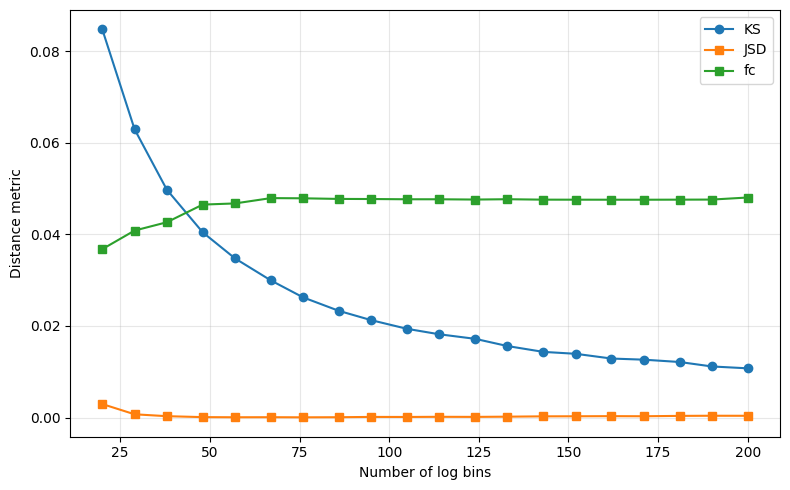

In [ ]:
nbins, KS, JSD, fc_hist, p50, p90 = map(np.array, zip(*records))

fig, ax1 = plt.subplots(figsize = (8,5))
ax1.plot(nbins, KS, 'o-', label='KS')
ax1.plot(nbins, JSD, 's-', label='JSD')
ax1.plot(nbins, fc_hist*5, 's-', label='fc')
# ax1.set_xscale('log')
ax1.set_xlabel('Number of log bins')
ax1.set_ylabel('Distance metric')
ax1.legend(); ax1.grid(alpha=0.3)
plt.tight_layout(); plt.show()

In [ ]:
def vsmear_modelling(tracer,zmin,zmax,dvfn='./'):
    """
    vsmear_modelling function:

    This function provide the probability distribution function (PDF) and the cumulative probability function (CDF) \
    of the redshift difference Delta_v from repeated observations of DESI Y3 tracers (e.g., LRG, ELG, QSO, BGS) \
    at a given redshift range [zmin, zmax]. This is to prepare for applying them to the mocks.

    Parameters:
    ----------
    - tracer : str
        The tracer type. Valid values are 'LRG', 'ELG', 'QSO', and 'BGS' or their subsamples.
    
    - zmin : float
        The minimum redshift of the range to be considered for selection.
    
    - zmax : float
        The maximum redshift of the range to be considered for selection.
    
    - dvfn : str, optional
        The directory path to store the output files (default is './').

    Returns:
    --------
    This function does not return any values but saves output to files in the specified directory (dvfn).
        - The PDF and CDF of DV for the specified redshift range are saved as `.npz` files.


    Example usage:
    --------------
    vsmear_modelling('LRG', 0.4, 0.6, dvfn='./output')
    """

    from desitarget.targetmask import desi_mask, bgs_mask
    from desitarget.targetmask import zwarn_mask as zmtl_zwarn_mask

    # Validate the tracer input
    
    d     = Table.read(repeatdir)
    # Set parameters for the selection and calculation process
    catasmin, catasmax, catasbin = -3, 6, 0.2
    goodkey = f"GOOD_{tracer[:3]}"
    if tracer == "QSO":
        catasmin = -2
    # Redrock redshift selections:
    # cut on redshift range

    dv_final = np.log10(abs(d['DV'][sel&selz]))  
    
    # provide the Delta_velocity distributions
    dens,bins = np.histogram(dv_final,bins=np.arange(catasmin,catasmax,catasbin),density=True)
    ## keep none-zero elements
    sel_clean = dens>0
    vmid      = (bins[1:]+bins[:-1])/2
    vmid      = vmid[sel_clean]
    ## save the observed PDF and CDF
    cdffn_data= f'{dvfn}/{tracer[:3]}_z{zmin:.1f}-{zmax:.1f}_CDF'
    if not os.path.exists(cdffn_data+'.npz'):       
        vbin_fine = 0.005
        dens_fine,bins_fine=np.histogram(dv_final,bins=np.arange(catasmin,catasmax,vbin_fine),density=True)
        cdf_data     = np.cumsum(dens_fine) * vbin_fine 
        np.savez(cdffn_data, vbin=(bins_fine[1:]+bins_fine[:-1])/2, pdf=dens_fine, cdf=cdf_data)    
    # interpolation for the observed Delta_v distribution
    vnewbin = 0.005
    vnew    = np.arange(vmid[0]-catasbin/2,vmid[-1]+catasbin/2+0.01,vnewbin)
    vnewmid = (vnew[1:]+vnew[:-1])/2
    kernel  = 0.3
    ## compute the modelled PDF and CDF and save them
    cdffn= f'{dvfn}/{tracer[:3]}_z{zmin:.1f}-{zmax:.1f}_kernel{kernel}_CDF'
    if not os.path.exists(cdffn+'.npz'):       
        interp  = gaussian_kde(dv_final, bw_method=kernel)
        pdf     = interp(vnewmid)
        cdf     = np.cumsum(pdf) * vnewbin  
        np.savez(cdffn, vbin=vnewmid, pdf=pdf, cdf=cdf)
    return 0

In [ ]:
sys.path.append('/global/homes/s/shengyu/desi_y3_redshift_errors/main/repeat_obs')
from model_redshift_errors import suggest_vbin, get_kcdf, generate_dv

tracer = 'QSO'
(zmin, zmax) = REDSHIFT_OVERALL[tracer]

dv = generate_dv(REPEAT_DIR, tracer, zmin, zmax)

In [194]:
grid, pdf, cdf, log_vbin, F = get_kcdf(dv, vmode = 'linear')

In [229]:
cdf_unique, ind = np.unique(cdf, return_index=True)
grid_unique = grid[ind]
inv_cdf = interp1d(
    cdf_unique / cdf_unique[-1],
    grid_unique,
    bounds_error=False,
    fill_value=(grid_unique[0], grid_unique[-1]),
    kind='linear'
)
np.random.seed(123)
u = np.random.uniform(0, 1, int(123456))
y = inv_cdf(u)

compute_quantites(y, 10000)

{'number': 123456,
 'median': 757.1302055165922,
 'RMS': 1158.5756898682964,
 'fc': 0.5759136858475894}

In [ ]:
dv_pos = dv[dv > 0]
print(len(dv_pos))
grid_p, pdf_p, cdf_p, log_vbin, F_p = get_kcdf(dv_pos)
print((1-F_p(3))*100)
dv_neg = dv[dv < 0]
print(len(dv_neg))
grid_n, pdf_n, cdf_n, log_vbin, F_n = get_kcdf(-dv_neg)
print((1-F_n(3))*100)

240620
0.19901041869879732
240465
0.26207412703347366


In [223]:
cdf_fn = '/pscratch/sd/s/shengyu/repeats/DA2/loa-v1/vmode/KCDF_QSO_z0.8-2.1_linear.npz'

data = np.load(cdf_fn, allow_pickle=True)
grid = data["grid"]   # y = log10(dv) for dv>0
cdf  = data["cdf"]
cdf, ind = np.unique(cdf, return_index=True)
grid = grid[ind]
F = lambda y: np.clip(np.interp(y, grid, cdf, left=0, right=1), 0, 1)

In [224]:
F(-10000)*100

0.10764834194267957